# Calculating Biomass

## Background

In this lesson we will calculate the Biomass for a section of the SJER site. We will be using the Canopy Height Model discrete LiDAR data product as well as field data collected by the TOS group at NEON. This lesson will calculate Biomass for individual trees in the forest. The calculation of biomass consists of four primary steps

1) Delineating individual tree crowns
2) Calculating predictor variables for all individuals
3) Collecting training data
4) Applying a regression model to estiamte biomass from predictors

In this lesson we will use a watershed segmentation algorithm for delineating tree crowns (step 1) and and a Random Forest (RF) machine learning algorithm for relating the predictor variables to biomass (part 4). The predictor variables were selected following suggestions by Gleason et al. (2012) and biomass estimates were determined from DBH (diamter at breast height) measurements following relationships given in Jenkins et al. (2003). 

## Objectives

I this lesson we will

1) Learn how to apply a guassian smoothing fernal for high-frequency spatial filtering
2) Apply a watershed segmentation algorithm for delineating tree crowns
3) Calculate biomass predictor variables from a CHM
4) See how to setup training data for Biomass predictions
5) Apply a Random Forest machine learning approach to calculate biomass

First we will import several of the typical libraries 

In [1]:
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
%matplotlib inline 

Next we will add libraries from skilearn which will help with the watershed delination, determination of predictor variables and random forest algorithm

In [2]:
#Import biomass specific libraries
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

Define a function that will allow us to plot our spatial data

In [3]:
#Define plot band array function

def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)


Define a function that will allow us to output geotiff files

In [4]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    

Now we will define the file path to our CHM file

In [5]:
chm_file = 'C:/RSDI_2017/Day4/Biomass/NEON_D17_SJER_DP3_256000_4106000_CHM.tif'

We will want to output the results with the same file information as the input, so we will gather the file name information

In [6]:
#Get info from chm file for outputting results
just_chm_file = os.path.basename(chm_file)
just_chm_file_split = just_chm_file.split(sep="_")

In [7]:
#Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

#Get the raster band object
chm_raster = chm_dataset.GetRasterBand(1)

#Get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

#Get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)

Now we will get the CHM data, plot it and save the figure

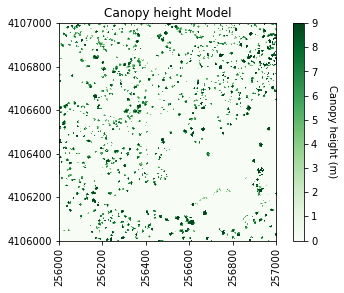

In [8]:
#Plot the original CHM
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

#PLot the CHM figure
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[0, 9])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'CHM.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)


Now we will run a Gaussian smoothing kernal (convolution) across the data set to remove spurious high vegetation points. This will help ensure we are finding the treetops properly before running the watershed segmentation algorithm. For different forest types it may be necessary to change the input parameters. Information on the function can be found at (https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.filters.gaussian_filter.html). Of most importance are the second and fourth inputs. The second input defines the standard deviation of the Gaussian smoothing kernal. Too large a value will apply too much smoothing, to small and some spurious high points may be left behind. The truncate value controls after how many standard deviations the Gaussian kernal will get cut off (since it theoretically goes to infinity).

In [9]:
#Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array,2,mode='constant',cval=0,truncate=2.0)
chm_array_smooth[chm_array==0] = 0 

Now save a copy of filtered CHM 

In [10]:
#Save the smoothed CHM
array2raster('C:/RSDI_2017/Day4/Biomass/chm_filter.tif',(xMin,yMax),1,-1,np.array(chm_array_smooth/10000,dtype=float),32611)

Now we will run an algorithm to determine local maximums within the image. Setting indices to 'False' returns a raster of the maximum points, as opposed to a list of coordinates. The footprint parameter is an area where only a single peak can be found. This should be approximately the size of the smallest tree. Information on more sophisticated methods to define the window can be found in Chen (2006).  

In [11]:
#Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth,indices=False, footprint=np.ones((5, 5)))

Plot the raster of local maximums. The following figure shows the difference in finding local maximums for a filtered vs. non-filtered CHM.

Max_filtred_non_filtered.JPG\n",

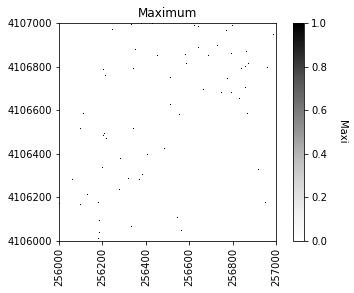

In [12]:
#Plot the local maximums
plt.figure(2)
plot_band_array(local_maxi,image_extent,'Maximum','Maxi','Greys',[0, 1])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'Maximums.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)


Apply labels to all of the local maximum points

In [13]:
#Identify all the maximum points
markers = ndi.label(local_maxi)[0]

Next we will create a mask layer of all of the vegettion points so that the watershed segmentation will only occur on the trees and not extend into the surrounding ground points. Since 0 represent ground points in the CHM, setting the mask to 1 where the CHM is not zero will define the mask

In [14]:
#Create a CHM mask so the segmentation will only occur on the trees
chm_mask = chm_array_smooth
chm_mask[chm_array_smooth != 0] = 1

Next we will perfrom the watershed segmentation, which produces a raster of labels

In [15]:
#Perfrom watershed segmentation        
labels = watershed(chm_array_smooth, markers, mask=chm_mask)

Max_filtred_non_filtered.JPG

Now we will get several properties of the individual trees which are used as predictor variables

In [16]:
#Get the properties of each segment
tree_properties = regionprops(labels,chm_array, ['Area','BoundingBox','Centroid','Orientation','MajorAxisLength','MinorAxisLength','MaxIntensity','MinIntensity'])

It was found that occasionally the segmenting skippen an integer number. We want to be able to match our segments to the trees in later steps, so we will create an array with only the segment numbers used.

In [17]:
#Determine how many individual trees were identified
max_labels = labels.max()
segment_labels = np.zeros(max_labels+1)
segment_id = np.zeros(max_labels+1)

for counter in range (1,max_labels+1):
    segment_labels[counter] = len(labels[labels==counter])
    segment_id[counter]=counter
    
#Remove the non-zero elements
segment_id = segment_id[np.nonzero(segment_labels)]
 


Next we will save the segments as a geotiff and plot them

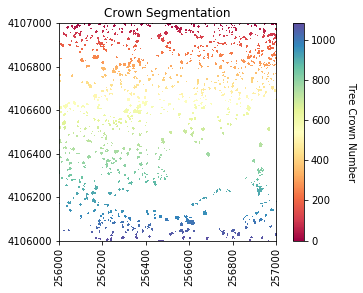

In [18]:
#Change the lebels to flow and plot them and save as raster
labels = np.array((labels),dtype=float)
plt.figure(3)
array2raster('C:/RSDI_2017/Day4/Biomass/SegmentedData.tif',(xMin,yMax),1,-1,labels,32611)
#Change the zero labels to nans so they won't show up in the plot
labels[labels==0] = np.nan
      
#Plot the segments      
plot_band_array(labels,image_extent,'Crown Segmentation','Tree Crown Number','Spectral',[0, max_labels])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'Segmentation.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)



Now we will define the predictor variables and begin to fill out their values

In [19]:
#Define several of the predictor variables
area=np.zeros(len(tree_properties))
diameter=np.zeros(len(tree_properties))
max_tree_height=np.zeros(len(tree_properties))
min_tree_height=np.zeros(len(tree_properties))

#Retreive the predictor variables from the region properties
for counter in range(0,len(tree_properties)):
    
    area[counter] = tree_properties[counter]['Area']
    diameter[counter] = tree_properties[counter]['MajorAxisLength']        
    max_tree_height[counter] =  tree_properties[counter]['MaxIntensity']    
    min_tree_height[counter] = tree_properties[counter]['MinIntensity']  


Now we will define the remaining predictor variables 

In [20]:
#Define the remaining predictor variables

crown_geometric_volume_full=np.zeros(len(segment_id))
crown_geometric_volume_50th_percentile=np.zeros(len(segment_id))
crown_geometric_volume_60th_percentile=np.zeros(len(segment_id))
crown_geometric_volume_70th_percentile=np.zeros(len(segment_id))
percentile_50th=np.zeros(len(segment_id))
percentile_60th=np.zeros(len(segment_id))
percentile_70th=np.zeros(len(segment_id))


We will now run through a loop of all tree segments and gather the remaining predictor variables which include height percentiles and crown geometric volume percentiles. Inside the loop, we use logical indexing to retrieve each individual tree. We then calculate our predictor variables of interest. 

In [21]:
#Cycle through all of the tree segments    
counter=0
for segment in segment_id:
    #Pull out the tree of interest
    indexes_of_tree = np.asarray(np.where(labels==segment)).T
    tree_data = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    #Calculate the geometric volume 
    crown_geometric_volume_full[counter]=np.sum([tree_data-np.min(tree_data)])
    
    #Pull out 50th percentile stats
    percentile_50th[counter]=np.percentile(tree_data,50)
    tree_data_50th = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    tree_data_50th[tree_data_50th>percentile_50th[counter]] = percentile_50th[counter]
    crown_geometric_volume_50th_percentile[counter]=np.sum([tree_data_50th-min_tree_height[counter]])
    
    #Pull out 60th percentile stats    
    percentile_60th[counter]=np.percentile(tree_data,60)
    tree_data_60th = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    tree_data_60th[tree_data_60th>percentile_60th[counter]] = percentile_60th[counter]
    crown_geometric_volume_60th_percentile[counter]=np.sum([tree_data_60th-min_tree_height[counter]])
    
    #Pull out 60th percentile stats 
    percentile_70th[counter]=np.percentile(tree_data,70)
    tree_data_70th = chm_array[indexes_of_tree[:,0],indexes_of_tree[:,1]]
    tree_data_70th[tree_data_70th>percentile_70th[counter]] = percentile_70th[counter]
    crown_geometric_volume_70th_percentile[counter]=np.sum([tree_data_70th-min_tree_height[counter]])
        
    counter=counter+1

We now bring in the training data file which is a simple CSV file with no header. The first column is biomass, and the remaining columns are the same predictor variables defined above. The tree diameter and max height were dfined in the TOS data along with the DBH. The field validated values are used for training, while the other were determined from the CHM and camera images by manually delineating the tree crowns and pulling out the relevant information from the CHM. Biomass was calculated from DBH accordaing to the formulas in Jenkins et al. (2003).  

In [22]:
#Define the file of training data  
training_data_file = 'C:/RSDI_2017/Day4/Biomass/training/SJER_Biomass_Training.csv'

#Read in the training data from a CSV file
training_data = np.genfromtxt(training_data_file,delimiter=',') 

#Grab the biomass (Y) from the first line
biomass = training_data[:,0]

#Grab the biomass prdeictors from the remaining lines
biomass_predictors = training_data[:,1:12]
    

We then define paraemters of the Random Forest classifier and fit the predictor variables from the training data to the Biomass estaimtes.

In [23]:
#Define paraemters for Random forest regressor
max_depth = 30

#Define regressor rules
regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)

#Fit the biomass to regressor variables
regr_rf.fit(biomass_predictors,biomass)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

Now we will gather the predictor variables gathered from all the segmented trees into a single array

In [24]:
#Stack the predictor variables for all the individual trees
all_training_data = np.stack([area,diameter,max_tree_height,min_tree_height,percentile_50th,percentile_60th,percentile_70th,crown_geometric_volume_full,crown_geometric_volume_50th_percentile,crown_geometric_volume_60th_percentile,crown_geometric_volume_70th_percentile],axis=-1)


We know apply the Random Forest model to the predictor variables to retreive biomass

In [25]:
#Apply the model to the 
pred_biomass = regr_rf.predict(all_training_data)

For outputting a raster, copy the labels raster to a biomass raster, then cycle through the segments and assign the biomass estaimte to each individual tree segment.

In [26]:
#Set an out raster with the same size as the labels
biomass_out = labels

#Set counter to zero
counter = 0
#Assign each tree by the associated biomass
for segment in segment_id:
    biomass_out[biomass_out==segment] = pred_biomass[counter]
    counter = counter+1

Collect some of the biomass statistics and then plot the results and save an output geotiff

Sum of biomass is  6978251.34548  kg


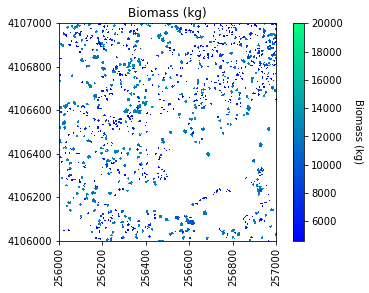

In [27]:
#Get biomass stats for plotting
mean_biomass = np.mean(pred_biomass)
std_biomass = np.std(pred_biomass)
min_biomass = np.min(pred_biomass)
sum_biomass = np.sum(pred_biomass)

print('Sum of biomass is ',sum_biomass,' kg')

#Plot the biomass!
plt.figure(5)
plot_band_array(biomass_out,image_extent,'Biomass (kg)','Biomass (kg)','winter',[min_biomass+std_biomass, mean_biomass+std_biomass*3])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'Biomass.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)
array2raster('biomass.tif',(xMin,yMax),1,-1,np.array(biomass_out,dtype=float),32611)
